In [10]:
import numpy as np
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

# load explanations that require convergence checks

In [11]:
#####lime
method='lime'
models=['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
expl_lime = {}

for model in models:
    filename = f'convergence/convergence_{method}_{model}.pkl'
    expl_lime[model] = pickle.load(open(filename, 'rb')) #change for each method
    
    

#####integrated gradients
method='integratedgrad'
models=['nn', 'nn_logistic']
expl_integratedgrad = {}

for model in models:
    filename = f'convergence/convergence_{method}_{model}.pkl'
    expl_integratedgrad[model] = pickle.load(open(filename, 'rb')) #change for each method

# #FFNN
# filename='convergence/convergence_integratedgrad_nn.pkl'
# expl_integratedgrad_nn = pickle.load(open(filename, 'rb'))
# #LR
# filename='convergence/convergence_integratedgrad_nn_logistic.pkl'
# expl_integratedgrad_nn_logistic = pickle.load(open(filename, 'rb'))


####smoothgrad
method='smoothgrad'
models=['nn', 'nn_logistic']
expl_smoothgrad = {}

for model in models:
    filename = f'convergence/convergence_{method}_{model}.pkl'
    expl_smoothgrad[model] = pickle.load(open(filename, 'rb')) #change for each method


# calculate + plot convergence metrics
- L2 attributions
- L2 feature importances
- rank correlations

In [12]:
#convert dict into df for plotting
# dict = {a: [1, 2, 3], b: [4, 5, 6]}
# df = 
# 'n'   'gap_metric'
#  a         1
#  a         2
#  a         3
#  b         4
#  b         5
#  b         6

def format_dict_for_boxplot(distr_dict, ns=[50, 100, 200, 400, 600, 800, 1000, 1500]):
    df_list = []
    for i in range(1, len(ns)):
        df = pd.DataFrame(distr_dict[ns[i]], columns=['gap_metric'])
        df['n'] = ns[i]
        df_list.append(df)
    df_full = pd.concat(df_list)
    return df_full

In [13]:
def convergence_analysis(expl_dict, plot_title, plot_path, ns=[50, 100, 200, 400, 600, 800, 1000, 1500]):
    #####calculate convergence metrics
    gaps_l2_attr = {}
    gaps_l2_feat_imp = {}
    gaps_rank_corr = {}
    
    print('calculating metrics for:')
    for i in range(1, len(ns)): #start at 1, so that 1st is compared with 0th
        print(f'   n={ns[i]}')
        n_curr = expl_dict[ns[i]]
        n_prev = expl_dict[ns[i-1]]

        #calculate L2(attributions at current n, attributions at previous n)
        gaps_l2_attr[ns[i]] = np.linalg.norm(n_curr-n_prev, axis=1)

        #calculate L2(feature importance at current n, feature importance at previous n)
        ranks_curr = np.argsort(-np.abs(n_curr), axis=1)
        ranks_prev = np.argsort(-np.abs(n_prev), axis=1)
        gaps_l2_feat_imp[ns[i]] = np.linalg.norm(ranks_curr-ranks_prev, axis=1)

        #calculate rank correlations at current n vs. previous n
        #https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable
        corrs = []
        for row in range(ranks_curr.shape[0]):
            rho, _ = spearmanr(ranks_curr[row, :], ranks_prev[row, :])
            corrs.append(rho)
        gaps_rank_corr[ns[i]] = corrs
    
    #####format dictionaries into df for plotting
    df_l2_attr = format_dict_for_boxplot(distr_dict=gaps_l2_attr, ns=ns)
    df_l2_feat_imp = format_dict_for_boxplot(distr_dict=gaps_l2_feat_imp, ns=ns)
    df_rank_corr = format_dict_for_boxplot(distr_dict=gaps_rank_corr, ns=ns)
    
    #####plot boxplots
    fig, axes = plt.subplots(1, 3, figsize =(20, 4))
    #L2 of attributions
    plot_l2_attrs = sns.boxplot(x='n', y='gap_metric', data=df_l2_attr, color='cornflowerblue', ax=axes[0])
    plot_l2_attrs.set(xlabel='n (samples per instance)', 
                      ylabel='L2(current n, previous n)', 
                      title='Attributions')
    #L2 of feature importances
    plot_l2_feat_imp = sns.boxplot(x='n', y='gap_metric', data=df_l2_feat_imp, color='cornflowerblue', ax=axes[1])
    plot_l2_feat_imp.set(xlabel='n (samples per instance)', 
                      ylabel='L2(current n, previous n)', 
                      title='Feature importances')
    #rank correlation
    plot_rank_corr = sns.boxplot(x='n', y='gap_metric', data=df_rank_corr, color='cornflowerblue', ax=axes[2])
    plot_rank_corr.set(xlabel='n (samples per instance)', 
                      ylabel='Rank correlation', 
                      title='Rank correlation')
    fig.suptitle(plot_title)
    fig.savefig(plot_path, facecolor='white', transparent=False)
    
    return gaps_l2_attr, gaps_l2_feat_imp, gaps_rank_corr
    
    

# convergence plots

### integrated gradients

calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500


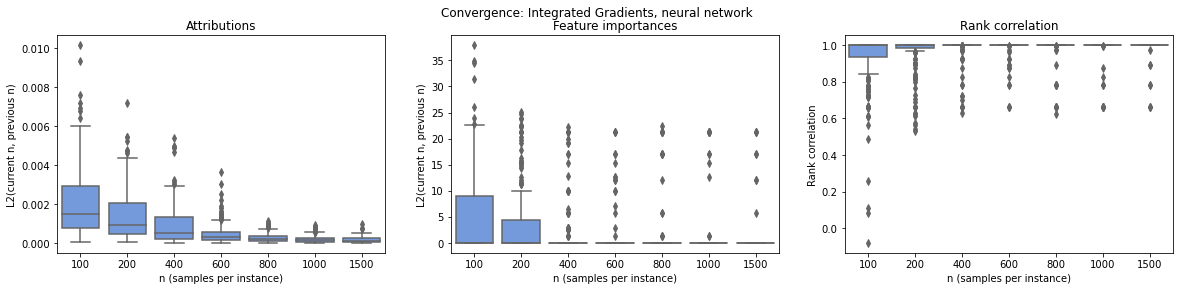

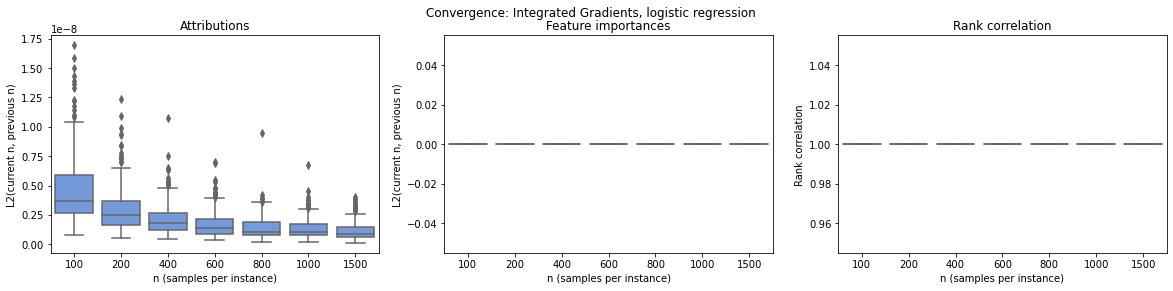

In [14]:
#####integrated gradients

#for calculation of metrics
method_dict = expl_integratedgrad 
#for plot title
method_name='Integrated Gradients' 
model_names=['neural network', 'logistic regression']
#for saving plot path
method='integratedgrad'
models=['nn', 'nn_logistic']

#plots
for i in range(len(models)):
    expl_dict = method_dict[models[i]]
    plot_title = f'Convergence: {method_name}, {model_names[i]}'
    plot_path = f'figures/convergence_{method}_{models[i]}.png'
    _, _, _ = convergence_analysis(expl_dict, plot_title, plot_path)


In [15]:
# ###integrated gradients

# #FFNN
# expl_dict=expl_integratedgrad_nn
# plot_title='Convergence: Integrated Gradients, FFNN'
# plot_path='figures/convergence_integratedgrad_nn.png'
# _, _, _ = convergence_analysis(expl_dict, plot_title, plot_path)


# #logistic
# expl_dict=expl_integratedgrad_nn_logistic
# plot_title='Convergence: Integrated Gradients, Logistic Regression'
# plot_path='figures/convergence_integratedgrad_logistic.png'
# _, _, _ = convergence_analysis(expl_dict, plot_title, plot_path)

### smoothgrad

calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500


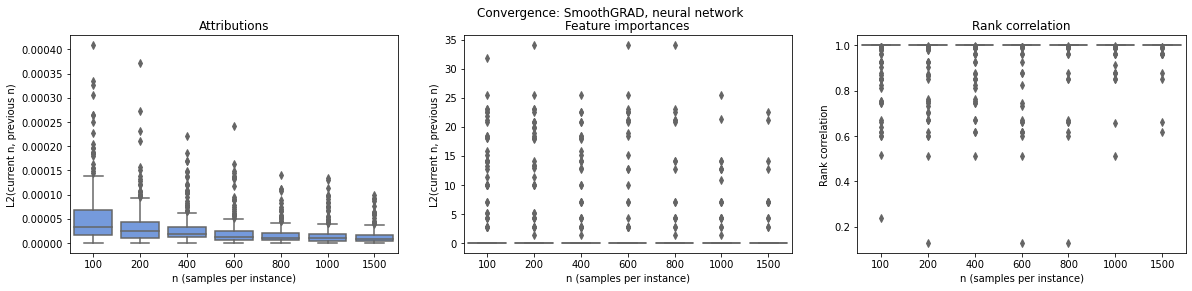

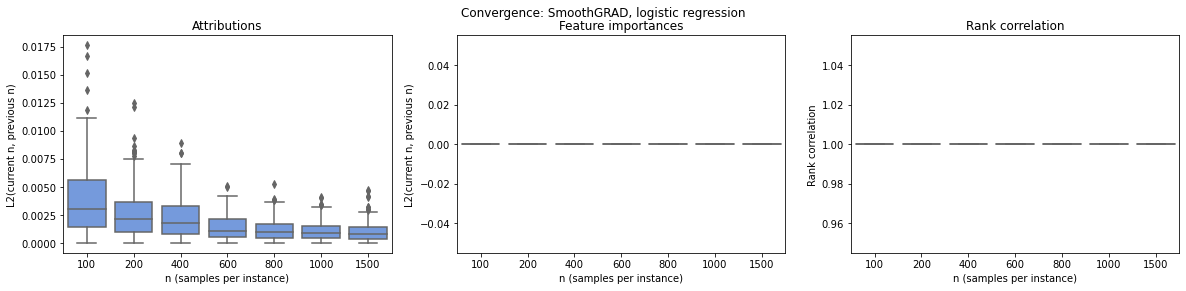

In [16]:
#####smoothgrad

#for calculation of metrics
method_dict = expl_smoothgrad
#for plot title
method_name='SmoothGRAD' 
model_names=['neural network', 'logistic regression']
#for saving plot path
method='smoothgrad'
models=['nn', 'nn_logistic']

#plots
for i in range(len(models)):
    expl_dict = method_dict[models[i]]
    plot_title = f'Convergence: {method_name}, {model_names[i]}'
    plot_path = f'figures/convergence_{method}_{models[i]}.png'
    _, _, _ = convergence_analysis(expl_dict, plot_title, plot_path)


### lime

calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
   n=2000
   n=2500
   n=3000
calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
   n=2000
   n=2500
   n=3000
calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
   n=2000
   n=2500
   n=3000
calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
   n=2000
   n=2500
   n=3000
calculating metrics for:
   n=100
   n=200
   n=400
   n=600
   n=800
   n=1000
   n=1500
   n=2000
   n=2500
   n=3000


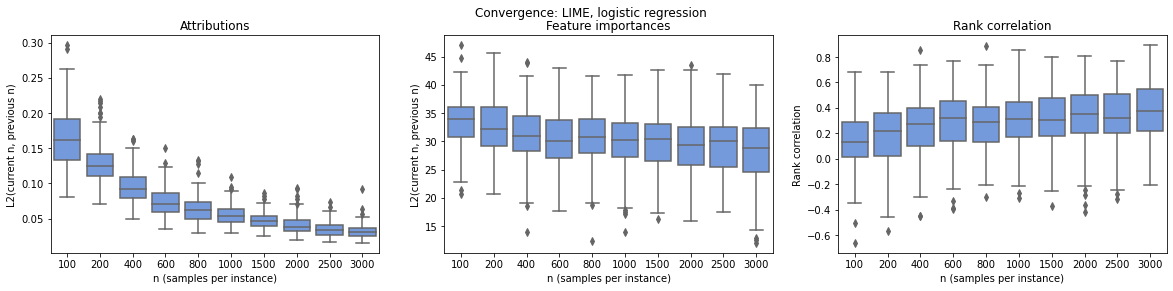

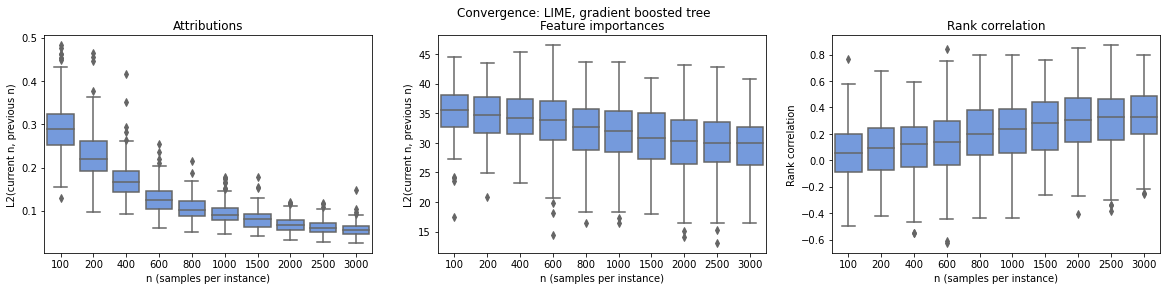

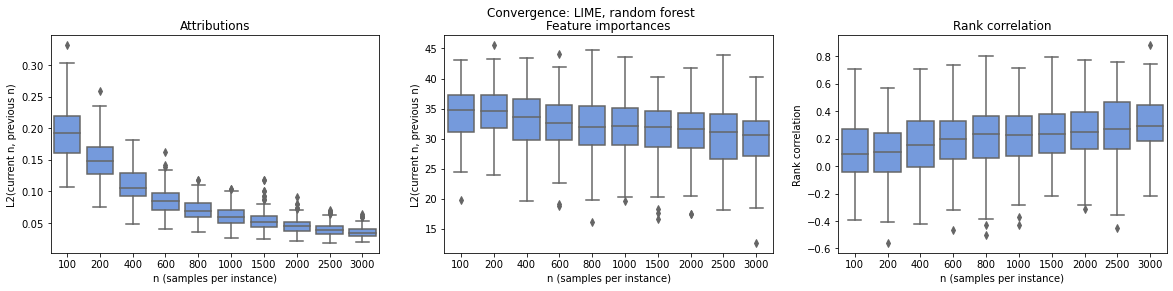

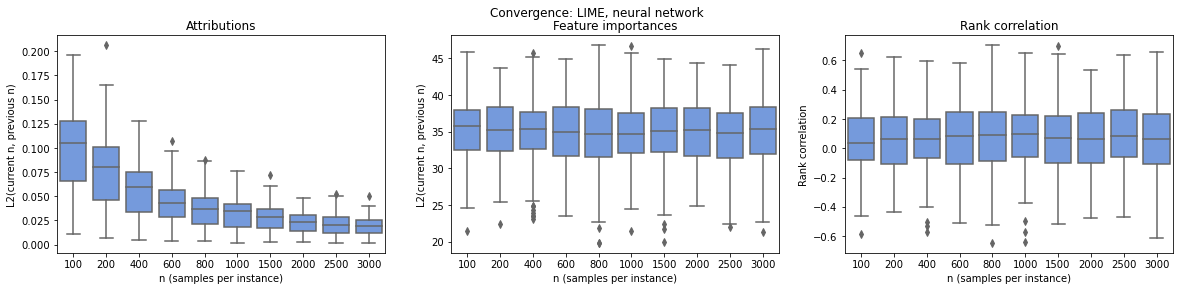

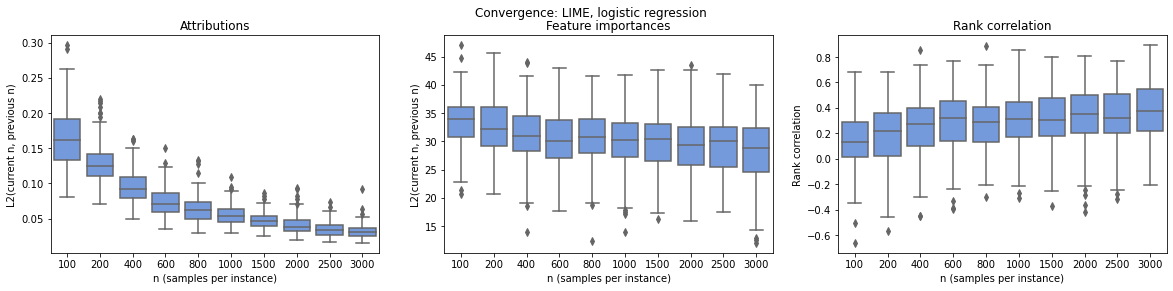

In [17]:
#####lime
#for calculation of metrics
method_dict = expl_lime
nsamples_list = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 2500, 3000]

#for plot title
method_name='LIME' 
model_names=['logistic regression', 'gradient boosted tree', 'random forest', 'neural network', 'logistic regression']
#for saving plot path
method='lime'
models=['logistic', 'gb', 'rf', 'nn', 'nn_logistic']

#plots
for i in range(len(models)):
    expl_dict = method_dict[models[i]]
    plot_title = f'Convergence: {method_name}, {model_names[i]}'
    plot_path = f'figures/convergence_{method}_{models[i]}.png'
    _, _, _ = convergence_analysis(expl_dict, plot_title, plot_path, ns=nsamples_list)
